Following up on the previous work thresholding CNVs, let's see what else we can get with the nonclean analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

**Also, remember that PLINK has a built in threshold of 20KB for minimum length!**

OK, let's plot them again to see what we find:

In [2]:
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']

# cleaning up the data for this analysis
fid = open('/home/sudregp/data/cnv/exclude.txt', 'r')
exclude_list = [line.rstrip() for line in fid]
fid.close()
fid = open('/home/sudregp/data/cnv/exclude_multikids.txt', 'r')
exclude_list += [line.rstrip() for line in fid]
fid.close()

trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if (fa[:4] in wes_prefix and mo[:4] in wes_prefix and
        sid[:4] in wes_prefix and sid not in exclude_list):
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)
good_kids = [t['child'] for t in trios]

print 'Working with %d samples, in %d families' % (len(samples), len(famids))

Working with 88 samples, in 20 families


In [3]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [6]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
files = glob.glob(data_dir + '/*q60_lenLT250*cnv.indiv')
files2 = [f for f in files if f.find('all') < 0]
files2.sort()
for f in files2:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10406
Best protected: 10128, 1976, 10448, 10215


Best disrupted: 10406, 10090, 10173, 10164, 10033, 10153, 1895, 10178, 10197
Best protected: 1976, 10094, 10131, 10448, 10215, 10182, 1892, 10128


Best disrupted: 10406
Best protected: 10128, 1976, 10215


Best disrupted: 10406, 10369, 10448, 10153, 10164, 10033, 10173, 10197
Best protected: 1976, 10094, 10128, 10215, 855, 1892, 10131, 10182, 1895


Best disrupted: 10406, 10369, 10164, 10153, 10033, 10448, 10173, 10197
Best protected: 1976, 10094, 10215, 855, 10128, 10182, 1895, 1892, 10090


Best disrupted: 
Best protected: 10448


Best disrupted: 10090, 10173, 1895, 855, 10164, 10128, 10178, 10033, 10197, 1892
Best protected: 1976, 10131, 10448, 10369, 10153, 10406, 10094, 10215


Best disrupted: 10090, 10173, 855, 10128, 10164, 10178, 10033, 1895, 10197
Best protected: 1976, 10131, 10448, 10369, 10094, 10153


Best disrupted: 10406, 10090, 10173, 10164, 10033, 10153, 855, 10178, 10197, 10369
Best protected: 1976, 10131, 10094, 10448, 10215, 10182, 1892, 1895


Best disrupted: 
Best protected: 10197


Best disrupted: 1892, 10153, 10197, 10448, 10164, 10178, 1976, 10094, 10182, 10128, 10033, 10173
Best protected: 10131, 10369, 855, 10406, 10215, 1895


Best disrupted: 
Best protected: 


Best disrupted: 10197, 1892, 10153, 10090, 10094, 10182, 10164, 10448, 10173, 10215
Best protected: 10369, 855, 10033, 10178, 1895


Best disrupted: 10197, 1892, 10153, 10094, 1976, 10448, 10164, 1895, 10173, 10182
Best protected: 855, 10033, 10369, 10178, 10128


Best disrupted: 
Best protected: 10197


Best disrupted: 10178, 10448, 1892, 10033, 10153, 10128, 10164, 1976, 10094
Best protected: 10131, 10215, 10369, 10090, 10406, 10182


Best disrupted: 1892, 10153, 10448, 1976, 10178, 10128, 10164, 10197, 10094, 10173
Best protected: 10215, 10131, 10090, 10406, 10369, 1895, 10182


Best disrupted: 1892, 10197, 10153, 1976, 10448, 10094, 10164, 10173, 10178
Best protected: 10369, 10131, 10215, 855, 10090, 10406, 10033


Running the non-clean dataset gives me more of a continuous variable, which would be more desirable for the correlation plots. Let's see how it looks:

In [7]:
from itertools import combinations
from scipy import stats


def compute_correlations(files, diff=False, p_thresh=.05, x='ncnv', min_points=20):
    pcorrs = []
    scorrs = []
    ptitles, stitles = [], []
    for f in files:
        # open PLINK file and grab the burden for all kids
        df = pd.read_table(f, delimiter='\s+', index_col=1)
        kids = [t['child'] for t in trios]
        ncnv = []
        for kid in kids:
            idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
            ncnv.append(int(df.iloc[idx]['NSEG']))
        df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
        data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
        data = pd.merge(data, df3, left_on='code', right_index=True)
        y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', x]]
        
        if diff:
            # the idea is to create a new data frame that only has the differences
            # among the phenotypes
            y_cols = [c for c in data.columns if c not in ['code', 'ID', 'MRN', 'ncnv']]
            # loop through families
            rows = []
            for fam in famids:
                fam_kids = [t['child'] for t in trios if t['famid'] == fam]
                # get all combinations of kids
                if len(fam_kids) > 1:
                    for kid1, kid2 in combinations(fam_kids, 2):
                        if kid1 in good_kids and kid2 in good_kids:
                            row1 = data[data['code'] == kid1]
                            row2 = data[data['code'] == kid2]
                            new_row = []
                            for y in (y_cols + [x]):
                                if np.float(row1[x]) > np.float(row2[x]):
                                    new_row.append(np.float(row1[y]) - 
                                                   np.float(row2[y]))
                                elif np.float(row2[x]) > np.float(row1[x]):
                                    new_row.append(np.float(row2[y]) - 
                                                   np.float(row1[y]))
                                else:
                                    new_row.append(np.nan)
                        rows.append(new_row)
            data = pd.DataFrame(rows, columns=(y_cols + [x]))

        # panda's corr() doesn't give p-vals, so let's do an ugly loop
        ps, ss = [], []
        for y in y_cols:
            tmp_df = data[[x, y]].dropna()
            r, p = stats.pearsonr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            # make sure we have enough points to compute a decent correlation
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ps.append(r)
            r, p = stats.spearmanr(tmp_df.iloc[:,0], tmp_df.iloc[:,1])
            if p > p_thresh or tmp_df.shape[0] < min_points:
                r = np.nan
            ss.append(r)
        # save the result if it's not NaN all across the board
        if not np.isnan(ps).all():
            pcorrs.append(ps)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            ptitles.append(t_str)
        if not np.isnan(ss).all():
            scorrs.append(ss)
            t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
            stitles.append(t_str)
            
    return (pd.DataFrame(pcorrs, index=ptitles, columns=y_cols),
            pd.DataFrame(scorrs, index=stitles, columns=y_cols))


# returns X and Y for a correlation plot
def get_xy(fname, ycol, diff=False, x='ncnv'):
    # open PLINK file and grab the burden for all kids
    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    kids = [t['child'] for t in trios]
    ncnv = []
    for kid in kids:
        idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
        ncnv.append(int(df.iloc[idx]['NSEG']))
    df3 = pd.DataFrame(ncnv, index=kids, columns=[x])
    data = pd.merge(df1, df2, left_on='ID', right_on='MRN')
    data = pd.merge(data, df3, left_on='code', right_index=True)
    
    if diff:
        # the idea is to create a new data frame that only has the differences
        # among the phenotypes
    
        # loop through families
        rows = []
        for fam in famids:
            fam_kids = [t['child'] for t in trios if t['famid'] == fam]
            # get all combinations of kids
            if len(fam_kids) > 1:
                for kid1, kid2 in combinations(fam_kids, 2):
                    if kid1 in good_kids and kid2 in good_kids:
                        row1 = data[data['code'] == kid1]
                        row2 = data[data['code'] == kid2]
                        if np.float(row1[x]) > np.float(row2[x]):
                            new_row = [np.float(row1[y]) - np.float(row2[y])
                                       for y in [ycol, x]]
                        elif np.float(row2[x]) > np.float(row1[x]):
                            new_row = [np.float(row2[y]) - np.float(row1[y])
                                       for y in [ycol, x]]
                        else:
                            new_row = [np.nan, np.nan]
                    rows.append(new_row)
        data = pd.DataFrame(rows, columns=[ycol, x])

    tmp_df = data[[x, ycol]].dropna()
    return tmp_df

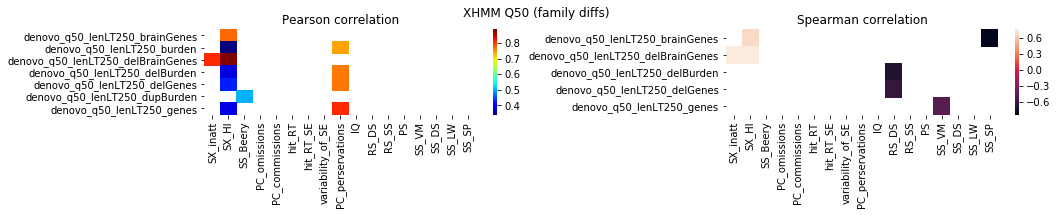

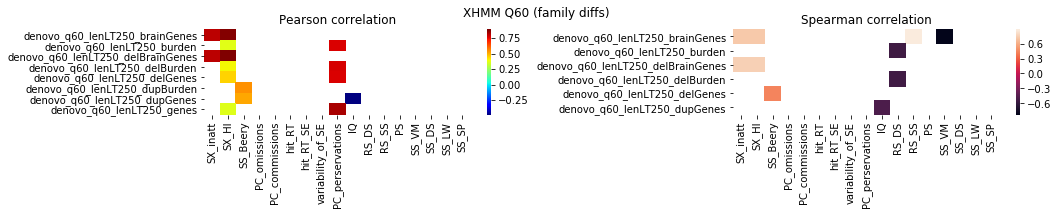

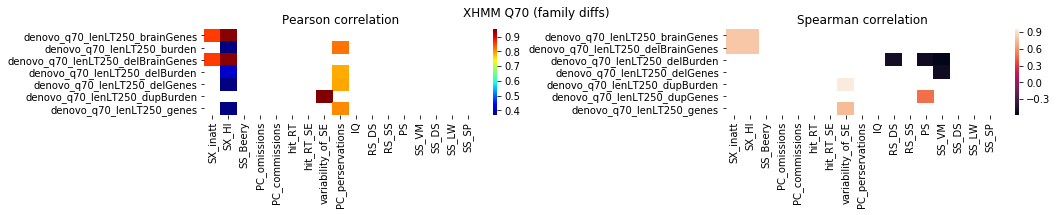

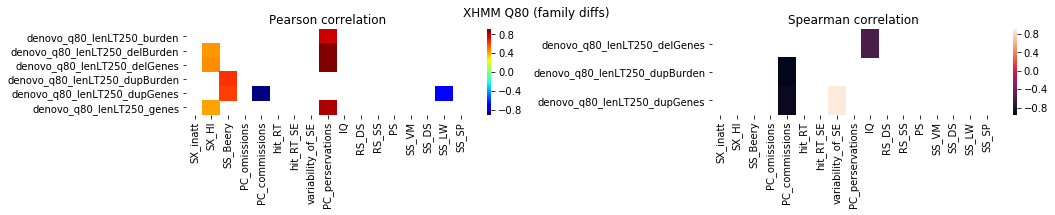

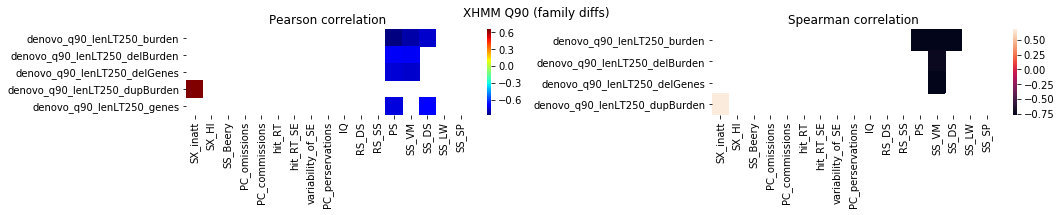

In [15]:
# note that even though I'm using the multiplex + simplex file, the trios 
# structure that is used by compute_correlations is based only on simplex
fname1 = '/home/sudregp/data/multiplex_simplex/sx_20180119.csv'
pheno1 = pd.read_csv(fname1)
fname2 = '/home/sudregp/data/multiplex_simplex/neuropsych_20180119_numbersOnly.csv'
pheno2 = pd.read_csv(fname2)
df2 = pd.merge(pheno1, pheno2, on='MRN', how='outer')

df1 = pd.read_table('/home/sudregp/data/multiplex_simplex/nisc_to_mrn.txt')

for q in [50, 60, 70, 80, 90]:
    data_dir = '/home/sudregp/data/cnv/xhmm_multikids/'
    files = [f for f in glob.glob(data_dir + '/*_q%d_*cnv.indiv' % q) 
             if f.find('DATA') < 0]
    files2 = [f for f in files if (f.find('denovo') >= 0 and 
                                   f.find('clean') < 0 and
                                   f.find('lenLT250') > 0)]# and
#                                    (f.find('urden') >= 0 or f.find('genes') > 0))]# and
#                                    (f.find('dup') > 0 or f.find('del') > 0))]
    files2.sort()
    pcorrs, scorrs = compute_correlations(files2, diff=True, min_points=5, p_thresh=.05)
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    if pcorrs.shape[0] > 0:
        sns.heatmap(pcorrs, cmap='jet', yticklabels=True)
        plt.title('Pearson correlation')
    if scorrs.shape[0] > 0:
        plt.subplot(1,2,2)
        sns.heatmap(scorrs, yticklabels=True)
        plt.title('Spearman correlation')
    plt.suptitle('XHMM Q%d (family diffs)' % q)
    plt.tight_layout()
    plt.show()

In [14]:
files

[]

These results would lead me to investigate further denovo_q60_clean_lenBT250_delBurden, but 500 also works. Let's see what we get there:

In [49]:
%%bash
cd /home/sudregp/data/cnv/xhmm_multikids/

for kid in CLIA_400205 CLIA_400216 CLIA_400204 CCGO_800980 CLIA_400178; do
    echo $kid
    grep -B 3 $kid denovo_q60_clean_lenLT250_delGenes.reg | grep RANGE;
done

CLIA_400205
RANGE (+/- 0kb )  [ 8 30689059 30706533 TEX15 ]
CLIA_400216
RANGE (+/- 0kb )  [ X 139865424 139866723 CDR1 ]
CLIA_400204
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
CCGO_800980
RANGE (+/- 0kb )  [ X 80369199 80457441 HMGN5 ]
CLIA_400178
RANGE (+/- 0kb )  [ 1 62901974 62917475 USP1 ]
RANGE (+/- 0kb )  [ 1 62920396 63154039 DOCK7 ]
RANGE (+/- 0kb )  [ 1 67390577 67454302 MIER1 ]
RANGE (+/- 0kb )  [ 1 93811477 93828148 DR1 ]
RANGE (+/- 0kb )  [ 2 48010220 48034092 MSH6 ]
RANGE (+/- 0kb )  [ 2 48034058 48132932 FBXO11 ]
RANGE (+/- 0kb )  [ 2 174771186 174830430 SP3 ]
RANGE (+/- 0kb )  [ 3 42642146 42690233 NKTR ]
RANGE (+/- 0kb )  [ 3 180319917 180336135 TTC14 ]
RANGE (+/- 0kb )  [ 3 180331795 180397283 CCDC39 ]
RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 4 68424445 68472616 STAP1 ]
RANGE (+/- 0kb )  [ 4 68481478 68566889 UBA6 ]
RANGE (+/- 0kb )  [ 4 100817406 100867883 DNAJB14 ]
RANGE (+/- 0kb )  [ 4 1

Two hits in the X chromossome? I didn't even remember we were looking into that... need to take a closer look. But LCORL is in 2, which is nice.

In [52]:
fid = open('/home/sudregp/data/cnv/xhmm_multikids/denovo_q60_clean_lenLT250_delGenes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
LCORL,2
CHD9,2
ABHD13,2
CCDC73,1
MED13,1
ETNK1,1
DNAJB14,1
CREBRF,1
CCDC168,1
LYSMD3,1


In [53]:
dfs = df.sort_values(by='count', ascending=False).head(3)
for index, count in dfs.iterrows():
    nlines = count[0]
    gene = index
    fid = open('/home/sudregp/data/cnv/xhmm_multikids/denovo_q60_clean_lenLT250_delGenes.reg')
    for line in fid:
        if line.find(gene) >= 0:
            print line.rstrip()
            for i in range(nlines + 1):
                line = fid.next()
                print line.rstrip()
    fid.close()

RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2    4     17845860     17879761    DEL     33.9        1   0.1898   0.1898
   1   CLIA_400204        2    4     17878089     17878822    DEL    0.733        1 0.004109 0.004109
RANGE (+/- 0kb )  [ 16 53088944 53361414 CHD9 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400178        2   16     53358611     53361477    DEL    2.866    0.978  0.01029  0.01029
   1   CLIA_400203        1   16     53358753     53361477    DEL    2.724   0.9769 0.009768  0.00977
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400158        1   13    108882417    108886344    DEL    3.927        1   0.2479   0.2479
   1   CLIA_400178        2   13    

# TODO
 * gene based analysis? adhd only?
 * inherited results?
 * run non-clean set as well, as it's possible that a combination of common variants is behind this, not only rare
 * correlations with other variables?
 * what's up with the chrX hits?
 * run unique multiplex with ADHD to find inherited variables?